---
title: "[stock prediction] 3.3 클러스터 탐색을 통한 주가상승 패턴 검출"
author: "agsu"
date: "7/25/2022"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [project, stock prediction]
image: ../image/stock8.png
---

# 3. 논문 연구: 주가상승 패턴 검출   
## 3.3. 클러스터 탐색을 통한 주가상승 패턴 검출 
지난 글 ( [3.2 t-SNE를 사용한 주가데이터 2차원 시각화](https://ag-su.github.io/blog/posts/06.tsne.html) ) 에서는 원본 주가데이터셋과 SHAP 표준화 데이터셋에 대한 t-SNE 2차원 산점도 시각화를 수행하여 SHAP 표준화 데이터셋의 군집의 경계가 더 명확하게 드러남을 확인하였다. 이번 글에서는 `SHAP 표준화 데이터셋`에 `계층적 클러스터링` 알고리즘을 적용하여 명시적으로 군집을 분류해보고, label1의 비율로 군집을 필터링하여 `상승 추세 군집`을 선택한다. 선택된 상승 추세 군집에서 빈도수 상위 날짜들의 개별 종목 차트를 확인하여 `공통된 패턴을 검출`한다. 


### 목차 
- (1) 계층적 클러스터링 & 상승 추세 군집 선택  
- (2) 정리

- 라이브러리 import  

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pymysql

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12,5)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothic')

import StockFunc as sf

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<br>
<br>

## (1) 계층적 클러스터링 & 상승 추세 군집 선택 
`상승 추세 군집`이란 **기준일 (D0) 대비 다음 날 (D+1) 종가 2% 이상 상승**한 데이터들이 일정 비율 이상 속하는 군집들을 의미한다. 계층적 클러스터링을 통해 생성된 군집들을 label1의 비율로 필터링하여 상승 추세 군집을 선택한다. 

- linkage, 덴드로그램 시각화 함수

계층적 클러스터링에서의 덴드로그램 시각화를 수행하여 트리의 높이를 결정할 수 있도록 한다. 

In [2]:
def hierarchical_clustering_plot(method, year, cci_type, dendrogram=False, n_clusters=5, min_samples=5, alpha=0.3, size=4):
    '''
    method: str / complete, average, ward
    year: int / 2019, 2020, 2021
    cci_type:int / 1, 2, 3
    dendrogram:Boolean / True, False(default) - 시간이 오래걸리므로 선택 
    n_clusters: int / default:5
    min_samples: int / default:5
    alpha: float / default: 0.3
    size: int / default: 4
    '''

    import pickle # tsne 파일 불러오기 
    with open(f'np_tsne_shap_{year}_{cci_type}', 'rb') as handle: 
        np_tsne = pickle.load(handle)
    
    if method in ('complete', 'average', 'ward'): # linkage method 선택 
        from scipy.cluster.hierarchy import linkage, dendrogram
        import matplotlib.pyplot as plt
        clusters = linkage(y=np_tsne, method=method, metric='euclidean')
        print("linkage complete")
        
        if dendrogram: # True: 덴드로그램 시각화 
            plt.title(f"{year} dendrogram", fontsize=15)
            dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
            plt.show() 
            
        return clusters 
        
    else:
        print("method를 잘못 입력하였습니다.")

- 계층적 클러스터링, 상승 추세 군집 선택 시각화

덴드로그램을 참고하여 `40 ~ 60개의 군집`이 형성되도록 t를 설정한다. 상승 추세 군집을 선택하기 위해 적절한 ratio(특정 집단에서의 label1의 비율)값을 지정해주는데, `군집의 개수는 4 ~ 10개`, `데이터의 개수는 3000 ~ 6000개` 사이가 되도록 설정한다. 

In [28]:
def fcluster_plot_and_filtering(np_clusters, year, cci_type, t=30, ratio=0.5, alpha=0.3, size=4, xlim=70, ylim=70):
    '''
    np_clusters: np.array
    year: int / 2019, 2020, 2021
    cci_type: int / 1, 2, 3 
    t: int / default: 30 (덴드로그램 트리의 높이) 
    ratio: float / default:0.5 (1의 비율이 지정)  
    '''
    
    from scipy.cluster.hierarchy import fcluster # 지정한 클러스터 자르기
    import pickle     
    
    
    with open('all_dataset', 'rb') as handle: # Code, Date, Label 정보가 모두 들어있는 데이터셋 불러오기
        dict_all_dataset = pickle.load(handle)
        
    with open(f'np_tsne_shap_{year}_{cci_type}', 'rb') as handle: # 연도, CCI 구간에 맞는 tsne 데이터셋 불러오기
        np_tsne = pickle.load(handle)
    
    df_shap_cci = dict_all_dataset[cci_type][1]
    df_shap_year = df_shap_cci[(df_shap_cci['Date'] >= f'{year}-01-01') & (df_shap_cci['Date'] <= f'{year}-12-31')].reset_index(drop=True) # 연도에 맞는 데이터 필터링
    
    cut_tree = fcluster(np_clusters, t=t, criterion='distance') # 군집화 결과 데이터 
    print("군집의 개수:", len(pd.DataFrame(cut_tree)[0].unique())) # 군집의 개수 출력 
    
    ##### 클러스터링 시각화 
    fig = plt.figure(figsize=(15, 5))
    ax1, ax2 = fig.subplots(1, 2)
        
    scatter = ax1.scatter(x=np_tsne[:, 0], y=np_tsne[:, 1], c=cut_tree, cmap='gist_rainbow', alpha=alpha, s=size) # 군집(cut_tree)별로 시각화 
    ax1.legend(*scatter.legend_elements())
    ax1.set_title(f"{year} Hierarchical Clustering", fontsize=15)
    
    ##### 라벨 1의 비율을 사용한 클러스터 필터링: 상승 추세 군집 선택
    df_tsne = pd.DataFrame(np_tsne, columns=['component1', 'component2'])
    df_tsne['Code'], df_tsne['Date'], df_tsne['Label'], df_tsne['Cluster'] = df_shap_year['Code'], df_shap_year['Date'], df_shap_year['Label'], cut_tree
    
    gb = df_tsne.groupby('Cluster')['Label'].value_counts(sort=False).unstack() # 군집 별 라벨 개수
    idx_label_1 = gb[gb[1]/(gb[0]+gb[1]) > ratio].index # label 1의 비율이 ratio 이상인 군집 번호
    print(f'label 1 > {ratio} 군집 번호: ', idx_label_1)
    df_tsne_1 = df_tsne[df_tsne['Cluster'].isin(idx_label_1)] # 라벨 1의 비율이 ratio 이상인 군집 추출 (상승 추세 군집)
    print("데이터의 개수:", len(df_tsne_1))
    print("종목의 종류:", df_tsne_1['Code'].nunique(), " | ", "날짜의 종류: ", df_tsne_1['Date'].nunique())
    
    ##### 상승 추세 군집 시각화 
    ax2.set_title(f"label 1 > {ratio}", fontsize=15)
    scatter = ax2.scatter(df_tsne_1['component1'],df_tsne_1['component2'],c=df_tsne_1['Cluster'], cmap='gist_rainbow', s=3, alpha=0.4)
    ax2.legend(*scatter.legend_elements())
    ax2.set_ylim(-ylim, ylim) # tsne 범위와 맞추기
    ax2.set_xlim(-xlim, xlim)
        
    return df_shap_year, df_tsne_1

- **주 컬럼** 생성 및 **빈도수 상위 주** 시각화 함수

**[주 컬럼 생성 참고]**  
-[(Python) 그 날짜가 몇 주째인지 계산하기](https://soooprmx.com/python-%EA%B7%B8-%EB%82%A0%EC%A7%9C%EA%B0%80-%EB%AA%87-%EC%A3%BC%EC%A7%B8%EC%9D%B8%EC%A7%80-%EA%B3%84%EC%82%B0%ED%95%98%EA%B8%B0/)

In [5]:
def visualization_week(data_list, week_num=3, day_num=5): # 빈도수 상위 주 시각화 
    ##### 주 컬럼 생성
    def get_week_no(target):  
        from datetime import timedelta

        firstday = target.replace(day=1)

        if firstday.weekday() == 6:
            origin = firstday
        elif firstday.weekday() < 3:
            origin = firstday - timedelta(days=firstday.weekday() + 1)
        else:
            origin = firstday + timedelta(days=6-firstday.weekday())

        return f'{target.month}월 {(target - origin).days // 7 + 1}주차'

    mpl.rcParams['font.family'] = 'NanumSquare'    
    fig = plt.figure(figsize=(11, 5))
    ax = fig.subplots(2, 3)
    lst_year = [2019, 2020, 2021]

    ##### 연도 별 상위 빈도수 주, 날짜 시각화 
    for i, data in enumerate(data_list): # 연도 별 데이터셋 
        data['Date'] = pd.to_datetime(data['Date']).dt.date # datetime type 변경 
        data['date_month_week'] = data['Date'].apply(get_week_no) # xx월 xx주차 컬럼 생성 
        df_week = pd.DataFrame(data['date_month_week'].value_counts().head(week_num)).reset_index().rename(columns={'index':'month-week', 'date_month_week':'count'}) # 빈도수 상위 주차 5개 
        df_day = pd.DataFrame(data['Date'].value_counts().head(day_num)).reset_index().rename(columns={'index':'Date', 'Date':'count'}) # 빈도수 상위 주차 5개 
        
        ax[0, i].set_title(f"<{lst_year[i]}년 빈도수 상위 주>")
        sns.barplot(data=df_week, x='count', y='month-week', palette="Pastel1", ax=ax[0, i])

        for height, p in enumerate(ax[0, i].patches):
            width = p.get_width()
            ax[0, i].text(width, height+0.2, f'{round(p.get_width())}', ha = 'center', size = 13)

        ax[1, i].set_title(f"<{lst_year[i]}년 빈도수 상위 날짜>")
        sns.barplot(data=df_day, x='count', y='Date', palette="Pastel1", ax=ax[1, i])

        for height, p in enumerate(ax[1, i].patches):
            width = p.get_width()
            ax[1, i].text(width , height+0.2, f'{round(p.get_width())}', ha = 'center', size = 13)
    
    plt.xlabel("")
    plt.ylabel("")
    
    plt.tight_layout()
    plt.show()

<br>

### 1) 중립구간 - CCI : (-20, 20)

#### I. 2019

- 덴드로그램 

linkage complete


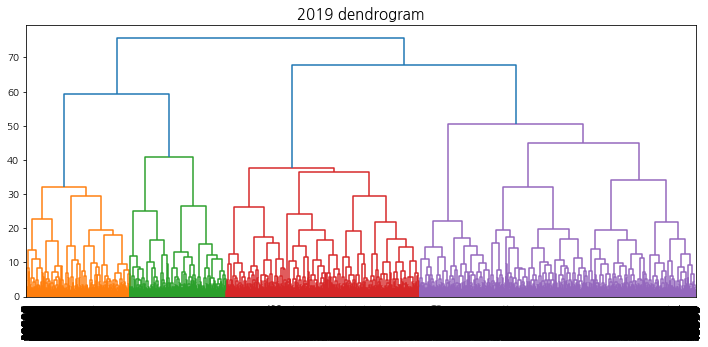

In [6]:
clusters_2019_1 = hierarchical_clustering_plot(method='average', year=2019, cci_type=1, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 53
label 1 > 0.22 군집 번호:  Int64Index([21, 23, 24, 26, 27, 36, 47, 49], dtype='int64', name='Cluster')
데이터의 개수: 4313
종목의 종류: 1024  |  날짜의 종류:  246


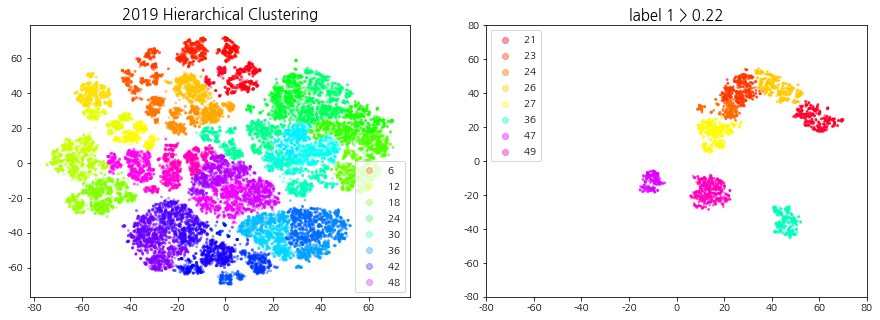

In [29]:
df_shap_2019_1, df_tsne_2019_1_1 = fcluster_plot_and_filtering(clusters_2019_1, 2019, 1, t=13, ratio=0.22, xlim=80, ylim=80)

<br>

#### II. 2020

- 덴드로그램 

linkage complete


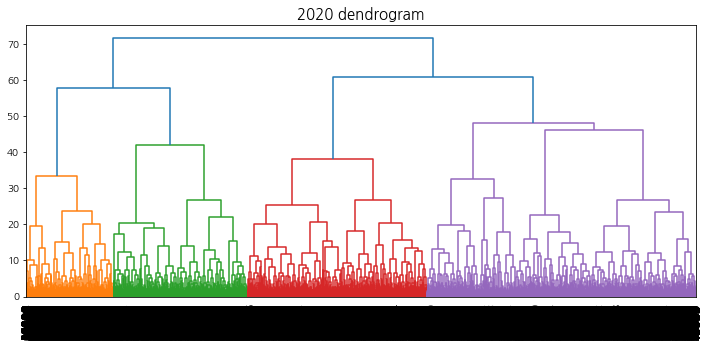

In [8]:
clusters_2020_1 = hierarchical_clustering_plot(method='average', year=2020, cci_type=1, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 53
label 1 > 0.29 군집 번호:  Int64Index([24, 26, 27, 30, 38, 40, 41, 42, 43], dtype='int64', name='Cluster')
데이터의 개수: 4827
종목의 종류: 1306  |  날짜의 종류:  247


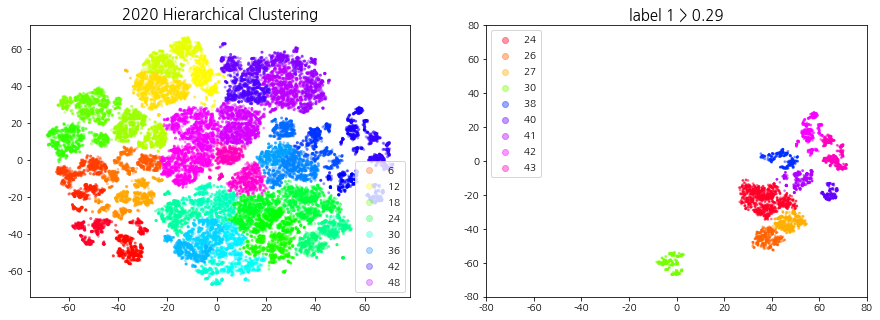

In [30]:
df_shap_2020_1, df_tsne_2020_1_1 = fcluster_plot_and_filtering(clusters_2020_1, 2020, 1, t=13, ratio=0.29, xlim=80, ylim=80)

<br>

#### III. 2021

- 덴드로그램 

linkage complete


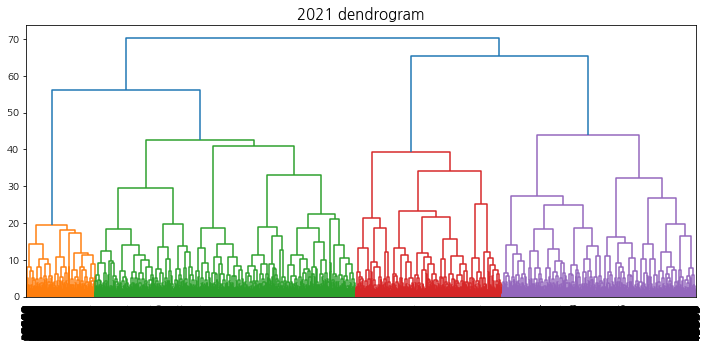

In [12]:
clusters_2021_1 = hierarchical_clustering_plot(method='average', year=2021, cci_type=1, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 51
label 1 > 0.207 군집 번호:  Int64Index([3, 4, 13, 18, 21, 22, 24, 25], dtype='int64', name='Cluster')
데이터의 개수: 4237
종목의 종류: 1092  |  날짜의 종류:  237


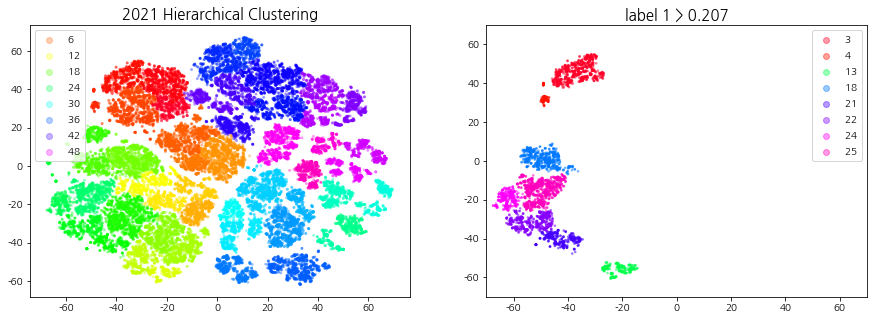

In [31]:
df_shap_2021_1, df_tsne_2021_1_1 = fcluster_plot_and_filtering(clusters_2021_1, 2021, 1, t=13, ratio=0.207)

<br>

#### 🌟 중립구간 상승 추세 군집 해석 

1) 연도별 빈도수 상위 주 & 날짜

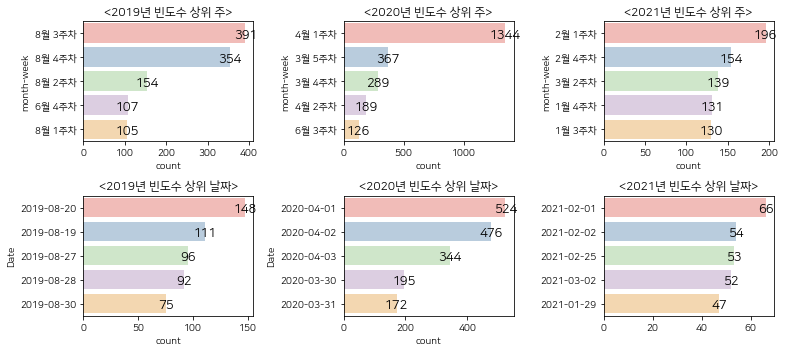

In [203]:
lst_data = [df_tsne_2019_1_1, df_tsne_2020_1_1, df_tsne_2021_1_1]
visualization_week(data_list=lst_data, week_num=5, day_num=5)

`중립구간`에서 상승 추세 군집 데이터의 날짜 빈도수는 **2019년도**는 **8월 3주차**, **2020년도**는 **4월 1주차**, **2021년도**는 **2월 1주차**가 가장 높게 나왔다. 그 중에서도 가장 큰 날짜 빈도 차이를 보인 연도는 **2020년**이었다.

<br>

2. 연도별 상위 날짜의 개별 종목 차트 확인 

- 연도별 상위 날짜의 랜덤 종목코드 데이터프레임 생성   

상위 날짜들을 바꿔가며 실행하고, 랜덤으로 나오는 종목코드들의 개별 종목 차트를 확인한다.  

In [14]:
#collapse-hide
import datetime
df_tsne_2019_1_1['Date'] = df_tsne_2019_1_1['Date'].astype(str)
df_tsne_2020_1_1['Date'] = df_tsne_2020_1_1['Date'].astype(str)
df_tsne_2021_1_1['Date'] = df_tsne_2021_1_1['Date'].astype(str)

df1 = df_tsne_2019_1_1.loc[df_tsne_2019_1_1['Date'] == '2019-08-20', ['Date', 'Code']].sample(5).reset_index(drop=True)
df2 = df_tsne_2020_1_1.loc[df_tsne_2020_1_1['Date'] == '2020-04-01', ['Date', 'Code']].sample(5).reset_index(drop=True)
df3 = df_tsne_2021_1_1.loc[df_tsne_2021_1_1['Date'] == '2021-02-01', ['Date', 'Code']].sample(5).reset_index(drop=True)

pd.concat([df1, df2, df3], axis=1)

,Date,Code,Date,Code,Date,Code
0,2019-08-20,007540,2020-04-01,160980,2021-02-01,023800
1,2019-08-20,047400,2020-04-01,119850,2021-02-01,033240
2,2019-08-20,010820,2020-04-01,041190,2021-02-01,038110
3,2019-08-20,020120,2020-04-01,024110,2021-02-01,039020
4,2019-08-20,081150,2020-04-01,002900,2021-02-01,001810


- 차트 확인 예시

**2019년 8월 20일**  
![image.png](attachment:5810adda-e94a-40e3-ba40-aa2999b0bdc0.png "종목코드: 082800")
 
**2020년 4월 1일**  
![image.png](attachment:1d44cba8-eb4c-40ab-824f-595ebe93dd73.png "종목코드: 089890")

**2021년 2월 1일**    
![image.png](attachment:e6f731bb-780b-438f-a325-bcd2c8e8b713.png "종목코드: 033240")
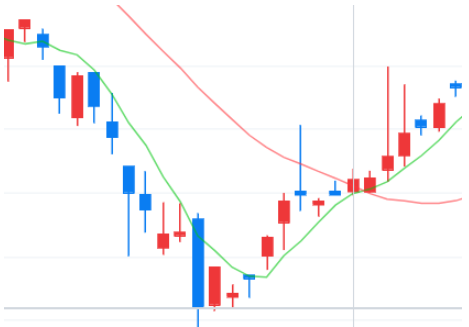
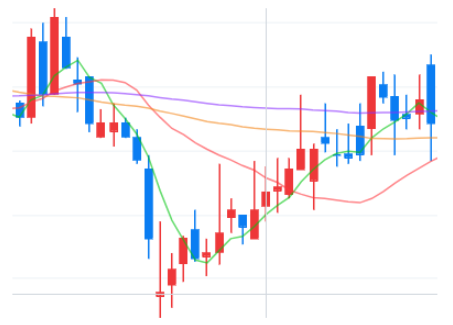
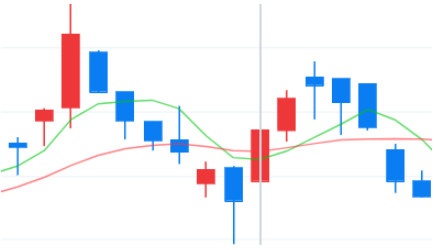

여러개의 차트 확인을 해보았을 때, 가장 큰 날짜 편중을 보였던 **2020년도**는 **차트의 패턴이 가장 일정**하게 나타났으며, 2019,2021년도는 2020년도 만큼 일정한 패턴을 보이지는 않았다. 하지만 세 연도에서 공통적으로 나오는 패턴이 존재했다. 해당 패턴을 분석해보았을 때, 위의 세 사진과 같이, `하락 추세에서 상승 추세로 전환`되는 `V자` 형태였으며, 그 중에서도 `기준일(D0)[회색 선]이 오른쪽에 위치`한다는 공통점이 있었다.  

<br>
<br>

### 2) 과열구간/과매수구간 - CCI : (100,  ∞ )

#### I. 2019

- 덴드로그램 

linkage complete


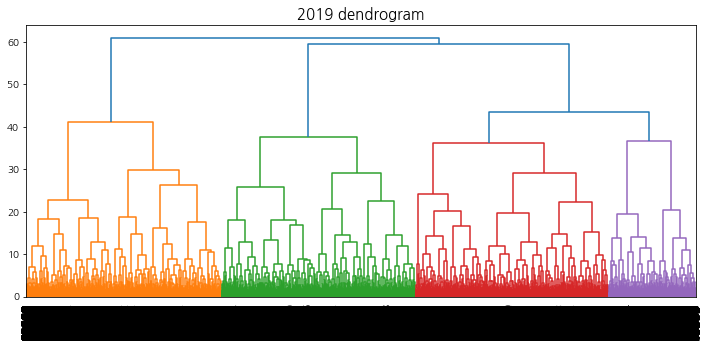

In [15]:
clusters_2019_2 = hierarchical_clustering_plot(method='average', year=2019, cci_type=2, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 48
label 1 > 0.25 군집 번호:  Int64Index([8, 16, 17, 21, 30], dtype='int64', name='Cluster')
데이터의 개수: 5016
종목의 종류: 1023  |  날짜의 종류:  246


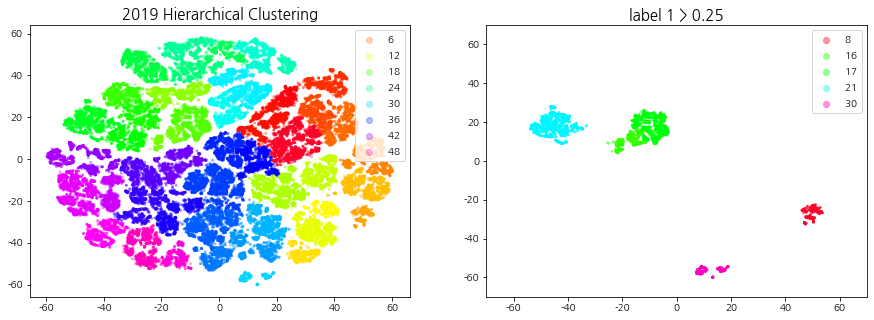

In [32]:
df_shap_2019_2, df_tsne_2019_1_2 = fcluster_plot_and_filtering(clusters_2019_2, 2019, 2, t=12, ratio=0.25)

<br>

#### II. 2020

- 덴드로그램 

linkage complete


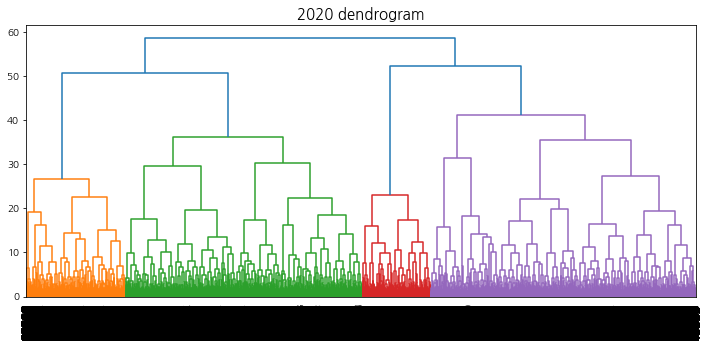

In [17]:
clusters_2020_2 = hierarchical_clustering_plot(method='average', year=2020, cci_type=2, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 55
label 1 > 0.31 군집 번호:  Int64Index([1, 14, 16, 22, 36, 39], dtype='int64', name='Cluster')
데이터의 개수: 5457
종목의 종류: 1190  |  날짜의 종류:  247


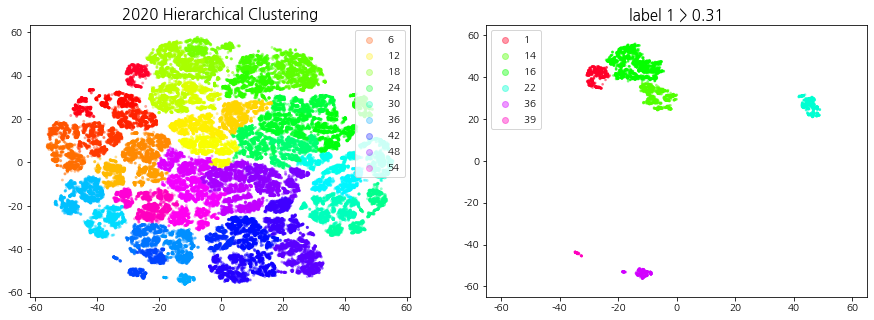

In [33]:
df_shap_2020_2, df_tsne_2020_1_2 = fcluster_plot_and_filtering(clusters_2020_2, 2020, 2, t=11, ratio=0.31, xlim=65, ylim=65)

<br>

#### III. 2021

- 덴드로그램 

linkage complete


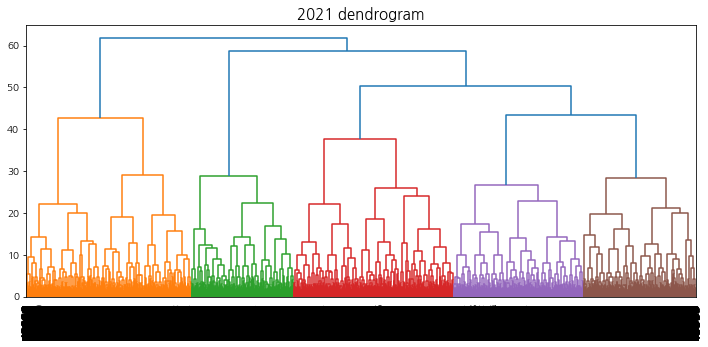

In [19]:
clusters_2021_2 = hierarchical_clustering_plot(method='average', year=2021, cci_type=2, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 52
label 1 > 0.268 군집 번호:  Int64Index([5, 9, 14, 16, 31, 32, 43, 51], dtype='int64', name='Cluster')
데이터의 개수: 5632
종목의 종류: 1110  |  날짜의 종류:  237


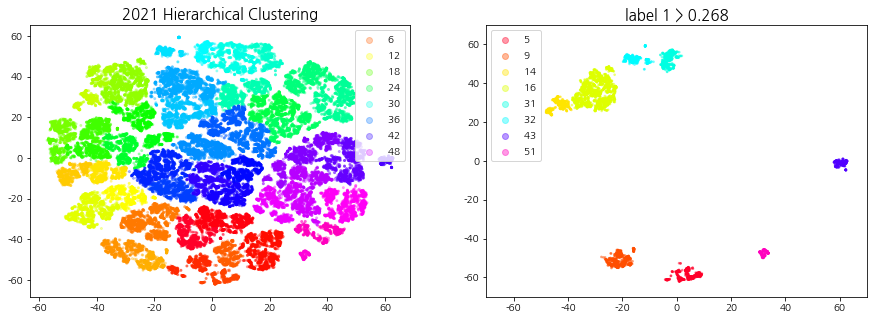

In [34]:
df_shap_2021_2, df_tsne_2021_1_2 = fcluster_plot_and_filtering(clusters_2021_2, 2021, 2, t=12, ratio=0.268)

<br>

#### 🌟 과매수구간 상승 추세 군집 해석 

1) 연도별 빈도수 상위 주 & 날짜

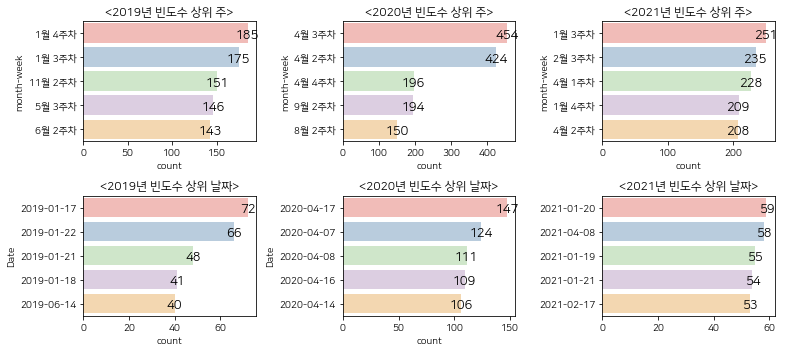

In [204]:
lst_data = [df_tsne_2019_1_2, df_tsne_2020_1_2, df_tsne_2021_1_2]
visualization_week(data_list=lst_data, week_num=5, day_num=5)

`과매수구간`에서 빈도수가 높은 날짜는 **2019년 1월 4주차**, **2020년 4월 3주차**, **2021년 1월 3주차**임을 알 수 있 습니다. 다른 CCI 구간에 비해 상위 빈도수의 크기 차이가 많지 않았다. 가장 높은 날짜 빈도 차이를 보이는 연도는 중립구간과 마찬가지로 **2020년도**였다. 

<br>

2) 연도별 상위 날짜의 개별 종목 차트 확인 

- 연도별 상위 날짜의 랜덤 종목코드 데이터프레임 생성   

상위 날짜들을 바꿔가며 실행하고, 랜덤으로 나오는 종목코드들의 개별 종목 차트를 확인한다.  

In [22]:
#collapse-hide
import datetime
df_tsne_2019_1_2['Date'] = df_tsne_2019_1_2['Date'].astype(str)
df_tsne_2020_1_2['Date'] = df_tsne_2020_1_2['Date'].astype(str)
df_tsne_2021_1_2['Date'] = df_tsne_2021_1_2['Date'].astype(str)

df1 = df_tsne_2019_1_2.loc[df_tsne_2019_1_2['Date'] == '2019-01-17', ['Date', 'Code']].sample(5).reset_index(drop=True)
df2 = df_tsne_2020_1_2.loc[df_tsne_2020_1_2['Date'] == '2020-04-17', ['Date', 'Code']].sample(5).reset_index(drop=True)
df3 = df_tsne_2021_1_2.loc[df_tsne_2021_1_2['Date'] == '2021-01-20', ['Date', 'Code']].sample(5).reset_index(drop=True)

pd.concat([df1, df2, df3], axis=1)

,Date,Code,Date,Code,Date,Code
0,2019-01-17,042370,2020-04-17,008250,2021-01-20,095340
1,2019-01-17,187220,2020-04-17,017550,2021-01-20,025880
2,2019-01-17,024900,2020-04-17,035620,2021-01-20,011500
3,2019-01-17,106240,2020-04-17,011370,2021-01-20,010690
4,2019-01-17,007390,2020-04-17,048430,2021-01-20,000270


- 차트 확인 예시

**2019년 1월 17일**  
![image.png](attachment:37f326f7-059b-4921-8558-cef135b24ee1.png "종목코드: 187220")

**2020년 4월 17일**  
![image.png](attachment:fd18d37b-2edd-45de-8645-14c7ed11280c.png "종목코드: 035620")

**2021년 1월 20일**  
![image.png](attachment:93e05fb5-8bf0-4904-befc-71203049da61.png "종목코드: 010690")
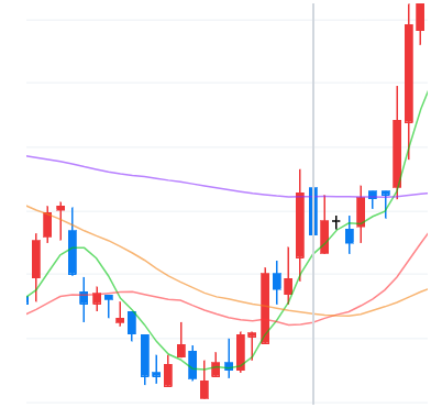
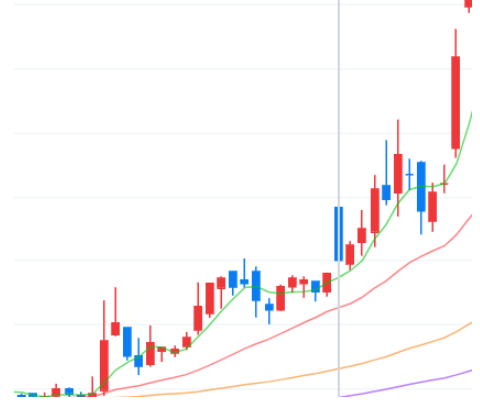
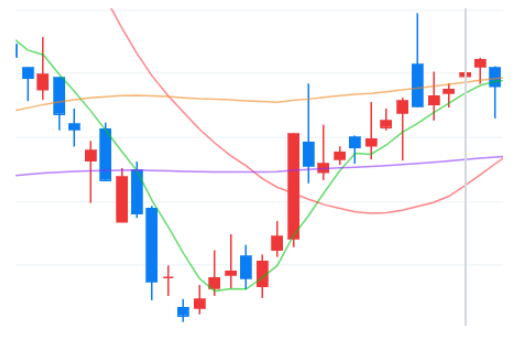

`과매수구간`은 20일 이동평균선의 위에 극단적으로 떨어져있는 데이터들이므로, 기준일(D0)[회색 선]이 상승추세에서의 중간 ~ 끝 무렵에 위치하였다. 다른 CCI 구간보다 패턴이 가장 불규칙적이었지만, `하락추세에서 상승추세로 전환되는 V자 형태에서 상승추세 끝무렵에 위치`하는 공통된 패턴을 **일부 데이터**에서 검출할 수 있었다.  

<br>
<br>

### 3) 침체구간/과매도구간 - CCI : (- ∞ ,-100)

#### I. 2019

- 덴드로그램 

linkage complete


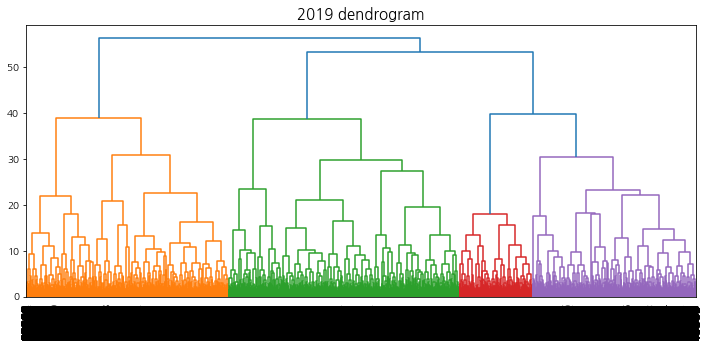

In [23]:
clusters_2019_3 = hierarchical_clustering_plot(method='average', year=2019, cci_type=3, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 58
label 1 > 0.365 군집 번호:  Int64Index([1, 2, 25, 26, 50], dtype='int64', name='Cluster')
데이터의 개수: 3959
종목의 종류: 994  |  날짜의 종류:  222


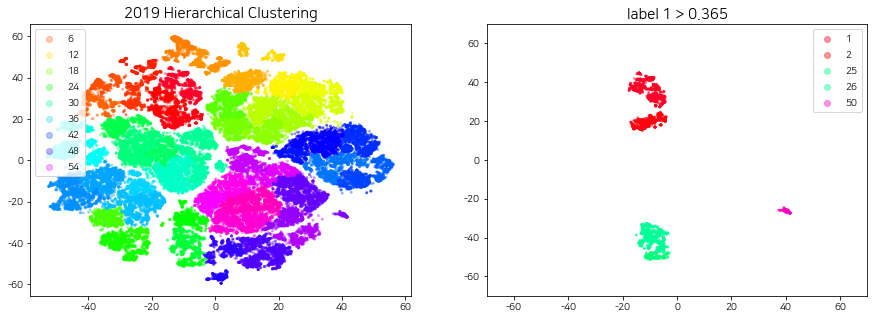

In [42]:
df_shap_2019_3, df_tsne_2019_1_3 = fcluster_plot_and_filtering(clusters_2019_3, 2019, 3, t=10, ratio=0.365)

<br>

#### II. 2020

- 덴드로그램 

linkage complete


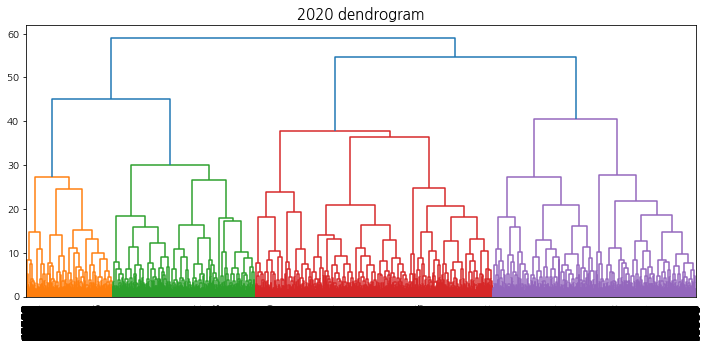

In [24]:
clusters_2020_3 = hierarchical_clustering_plot(method='average', year=2020, cci_type=3, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 47
label 1 > 0.5 군집 번호:  Int64Index([2, 3, 15, 28, 37], dtype='int64', name='Cluster')
데이터의 개수: 3874
종목의 종류: 1356  |  날짜의 종류:  78


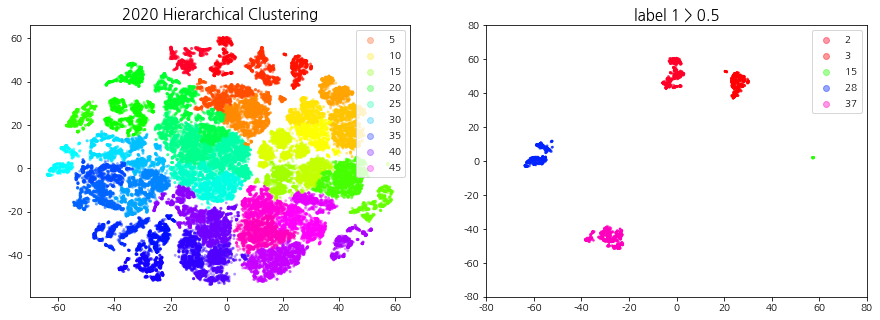

In [36]:
df_shap_2020_3, df_tsne_2020_1_3 = fcluster_plot_and_filtering(clusters_2020_3, 2020, 3, t=12, ratio=0.5, xlim=80, ylim=80)

<br>

#### III. 2021

- 덴드로그램 

linkage complete


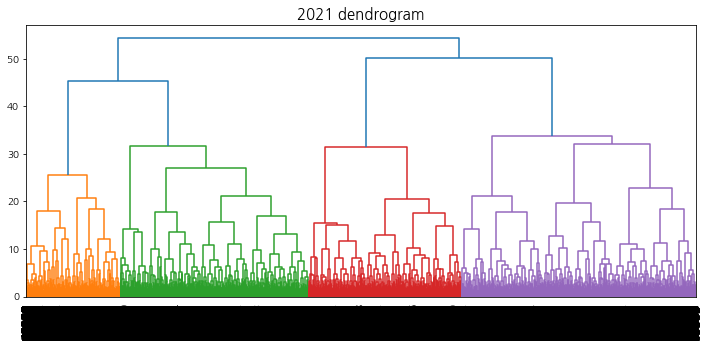

In [25]:
clusters_2021_3 = hierarchical_clustering_plot(method='average', year=2021, cci_type=3, dendrogram=True)

- 계층적 클러스터링 & 상승 추세 군집 선택  

군집의 개수: 53
label 1 > 0.35 군집 번호:  Int64Index([5, 7, 10, 15], dtype='int64', name='Cluster')
데이터의 개수: 4174
종목의 종류: 1163  |  날짜의 종류:  230


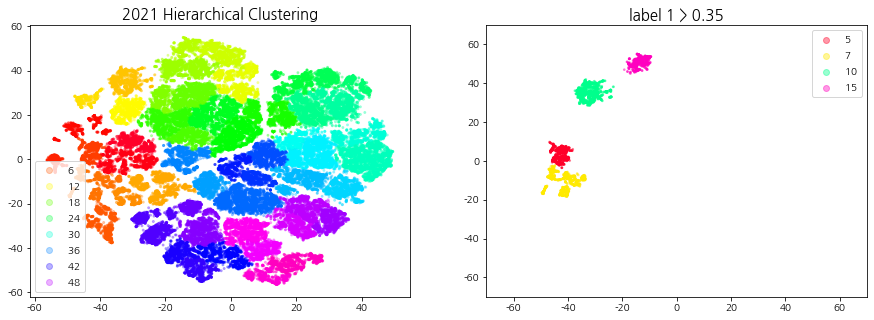

In [38]:
df_shap_2021_3, df_tsne_2021_1_3 = fcluster_plot_and_filtering(clusters_2021_3, 2021, 3, t=10, ratio=0.35)

<br>

#### 🌟 과매도구간 상승 추세 군집 해석 

1) 연도별 빈도수 상위 주 & 날짜

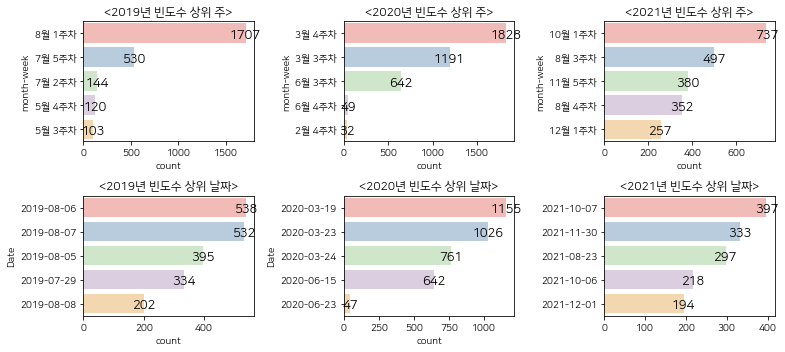

In [43]:
lst_data = [df_tsne_2019_1_3, df_tsne_2020_1_3, df_tsne_2021_1_3]
visualization_week(data_list=lst_data, week_num=5, day_num=5)

`과매도구간`의 빈도수 상위 날짜는 **2019년 8월 1주차**, **2020년 3월 4주차**, **2021년 10월 1주차**였다. CCI 구간 중 유일하게 모든 연도에서 높은 날짜 빈도 차이를 보였다.  

<br>

2) 연도별 상위 날짜의 개별 종목 차트 확인 

- 연도별 상위 날짜의 랜덤 종목코드 데이터프레임 생성   

상위 날짜들을 바꿔가며 실행하고, 랜덤으로 나오는 종목코드들의 개별 종목 차트를 확인한다.  

In [206]:
#collapse-hide
import datetime
df_tsne_2019_1_3['Date'] = df_tsne_2019_1_3['Date'].astype(str)
df_tsne_2020_1_3['Date'] = df_tsne_2020_1_3['Date'].astype(str)
df_tsne_2021_1_3['Date'] = df_tsne_2021_1_3['Date'].astype(str)

df1 = df_tsne_2019_1_3.loc[df_tsne_2019_1_3['Date'] == '2019-08-06', ['Date', 'Code']].sample(5).reset_index(drop=True)
df2 = df_tsne_2020_1_3.loc[df_tsne_2020_1_3['Date'] == '2020-03-19', ['Date', 'Code']].sample(5).reset_index(drop=True)
df3 = df_tsne_2021_1_3.loc[df_tsne_2021_1_3['Date'] == '2021-10-07', ['Date', 'Code']].sample(5).reset_index(drop=True)

pd.concat([df1, df2, df3], axis=1)

,Date,Code,Date,Code,Date,Code
0,2019-08-06,033100,2020-03-19,126880,2021-10-07,028300
1,2019-08-06,060480,2020-03-19,000850,2021-10-07,088130
2,2019-08-06,014190,2020-03-19,170920,2021-10-07,042110
3,2019-08-06,123860,2020-03-19,189860,2021-10-07,081000
4,2019-08-06,067990,2020-03-19,079160,2021-10-07,002690


- 차트 확인 예시

**2019년 8월 6일**   
![image.png](attachment:e5aad13f-b5ab-4589-84b6-3cb023521430.png "종목코드: 033100")

**2020년 3월 19일**   
![image.png](attachment:6ce4c3be-d169-4484-9d60-275e8fa2aa1b.png "종목코드: 126880")

**2021년 10월 17일**    
![image.png](attachment:08ea2063-05eb-4861-b19a-9e6cb11ca11a.png "종목코드: 088130")
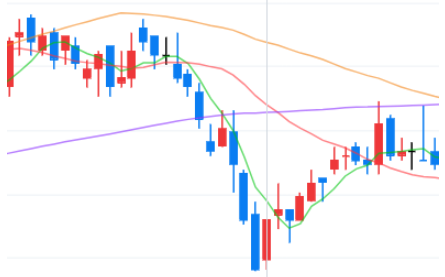
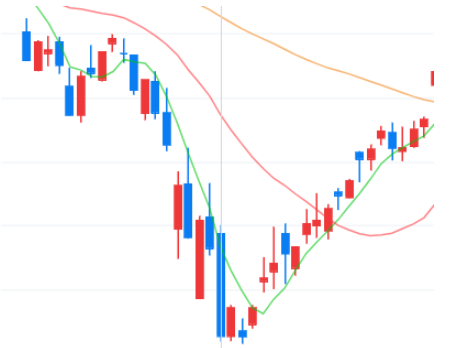
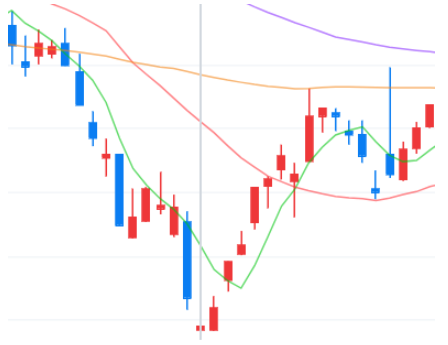

위의 사진과 같이, 모든 연도에서 비슷한 패턴을 보였다. `하락추세에서 상승추세로 전환되는 V자 형태`의 공통된 패턴에서, `기준일(D0)[회색 선]이 꼭지점 근처에 위치`하였다.

<br>
<br>

## (2) 정리

지금까지 `분류 머신러닝 모델학습`, `SHAP 표준화`, `클러스터링 분석`의 과정을 거쳐 `10일 간의 주가 시계열 데이터로`부터 주가 `상승 추세 패턴`을 검출하였다.

CCI 구간 별, 연도 별로 나누어 연구를 진행하였는데, 

1\) **CCI 구간** 별 공통적으로 나타나는 패턴은 **하락추세에서 상승추세로 전환되는 V자 상승반전형 패턴**이었으며, 기준일(D0)의 위치가 CCI 구간에 따라 다르게 나타났다. 특히나 `과매도구간`에서의 패턴이 다른 구간에 비해 가장 정확하고 유사한 것을 확인할 수 있었다.

2\) 모든 CCI 구간을 통틀어 **2019, 2020, 2021년도** 중 높은 빈도로 나타나는 날짜의 편중이 가장 큰 연도는 **2020년**이었으며, 2020년도에서 패턴의 모양 또한 가장 유사하게 나타났다. 